# Get all the imports necessary

In [1]:
# using GuSTO
include("../src/GuSTO.jl")
using AstrobeeRobot
using Plots
using JLD2, FileIO
using Plots
using BenchmarkTools
using Statistics
using HDF5
using Keras
import Plots.Animation

┌ Info: Precompiling BulletCollision [b3564421-7037-56b3-90f4-5b7f54e2ead3]
└ @ Base loading.jl:1192


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/75259c676c4c94b02ca26a89265c53e5a244a54a-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/75259c676c4c94b02ca26a89265c53e5a244a54a-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

# Only Freeflyer models to be used

In [22]:
robot = Freeflyer()
model = FreeflyerSE2()

FreeflyerSE2(6, 3, 0.05, Any[], Any[], Any[])

# Extract duals from GuSTO runs 

In [53]:
env = setUpEnvironmentNoObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
num_problems = 500
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 3

# Input is now (6*20) + (3*20) + 2 +6 = 188 
# Output is now 6*20) + (3*20) +6 = 186
train_input_collected_first_only = Array{Float64}(undef,0,188)
train_output_collected_first_only = Array{Float64}(undef,0,186)

train_input_collected = Array{Float64}(undef,0,188)
train_output_collected = Array{Float64}(undef,0,186)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 

        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
        traj_init = init_traj_straightline(TOP)
        
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        traj_X_vec_first_only = [traj_init.X]
        traj_U_vec_first_only = [traj_init.U]
        dual_vec = [zeros(6)]
        
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        push!(traj_X_vec_first_only, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec_first_only, TOSgusto.SCPS.traj.U)
        push!(dual_vec, TOSgusto.SCPS.dual)
        iterCount = 1
        @show dual_vec
        
        while !TOSgusto.SCPS.converged && iterCount <max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED 
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                push!(dual_vec, TOSgusto.SCPS.dual)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        
        if TOSgusto.SCPS.scp_status[end] == :OK 
            if TOSgusto.SCPS.converged
                println("Saving data solution converged and is OK")
                train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec, dual_vec)
                train_input_first_only, train_output_first_only = createTrainingInputAndOutput(traj_X_vec_first_only, traj_U_vec_first_only, TOSgusto.SCPS.param.alg.ω_vec[1:2], TOSgusto.SCPS.param.alg.Δ_vec[1:2], dual_vec[1:2])
                
                train_input_collected = vcat(train_input_collected, train_input)
                train_output_collected = vcat(train_output_collected, train_output)
                train_input_collected_first_only = vcat(train_input_collected_first_only, train_input_first_only)
                train_output_collected_first_only = vcat(train_output_collected_first_only, train_output_first_only)
                # Verifying that the correct duals are being stored
                # @show train_input[:,183:188]
                # @show train_output[:,181:186]
                # @show dual_vec
            else
                println("solution is ok but DID NOT converge")
            end
        else
            @show TOSgusto.SCPS.scp_status
            println("solution DID NOT end in OK")
            if TOSgusto.SCPS.converged
                println("solution converged")
            else
                println("solution DID NOT converge")
            end
        end

        problemNumber = problemNumber + 1
        @save "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelWithDuals.jld2" train_input_collected train_output_collected
        @save "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterWithDuals.jld2" train_input_collected_first_only train_output_collected_first_only
    end
end


problemNumber = 1
dual_vec = Array{Float64,1}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.03709, -0.00394881, 0.0, 1.48347, -0.158943, 0.0]]
iterCount = 2
iterCount = 3
Saving data solution converged and is OK
size(train_input) = (3, 188)
train_input[:, 183:188] = [0.0 0.0 0.0 0.0 0.0 0.0; 1.03709 -0.00394881 0.0 1.48347 -0.158943 0.0; 1.03709 -0.0039488 0.0 1.48347 -0.158943 0.0]
train_output[:, 181:186] = [1.03709 -0.00394881 0.0 1.48347 -0.158943 0.0; 1.03709 -0.0039488 0.0 1.48347 -0.158943 0.0; 1.03709 -0.0039488 0.0 1.48347 -0.158943 0.0]
dual_vec = Array{Float64,1}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.03709, -0.00394881, 0.0, 1.48347, -0.158943, 0.0], [1.03709, -0.0039488, 0.0, 1.48347, -0.158943, 0.0], [1.03709, -0.0039488, 0.0, 1.48347, -0.158943, 0.0]]

problemNumber = 2
dual_vec = Array{Float64,1}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.03709, -0.0185269, 0.0, 1.48347, -0.741735, 0.0]]
iterCount = 2
iterCount = 3
Saving data solution converged and is OK
size(train_input) = (3, 188)
train_i

In [43]:
@show dual_vec

UndefVarError: UndefVarError: dual_vec not defined

# Add NN to GuSTO

In [175]:
env = setUpEnvironmentNoObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
x_init = [0.2; 1.4; 0; 0; 0; 0] 

TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
traj_init = init_traj_straightline(TOP)

traj_init_X = traj_init.X
traj_init_U = traj_init.U

traj_X_vec = [traj_init_X]
traj_U_vec = [traj_init_U]

ω0 = 1.0 
Δ0 = 3.0

filename = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelParams.h5"
xMin, yMin, xRange, yRange = getDataParamsFromHDF5(filename)

NN_input = createNNInput(traj_init_X, traj_init_U, ω0, Δ0, xMin, xRange)

jsonFileName = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedB.json"
weightsFileName = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedBWeights.h5"
NN = Keras.load(jsonFileName, weightsFileName)

NN_output_diff = NN(NN_input)

output_X, output_U = recoverXUfromNNOutput(NN_output_diff, NN_input, xMin, xRange, yMin, yRange)

push!(traj_X_vec, output_X)
push!(traj_U_vec, output_U)



# SCPS = TOSgusto.SCPS 
# SCPP = TOSgusto.SCPS.SCPP

# solve_gusto_jump_NN!(SCPS, SCPP, jsonFileName, weightsFileName, "Ipopt", max_iter=1, print_level=0)

2-element Array{Array{Float64,2},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]                                                         
 [0.00176599 0.00157789 … -0.0412679 -0.0437881; -0.0304849 -0.0287556 … 0.00059762 0.000671807; 0.0 0.0 … 0.0 0.0]

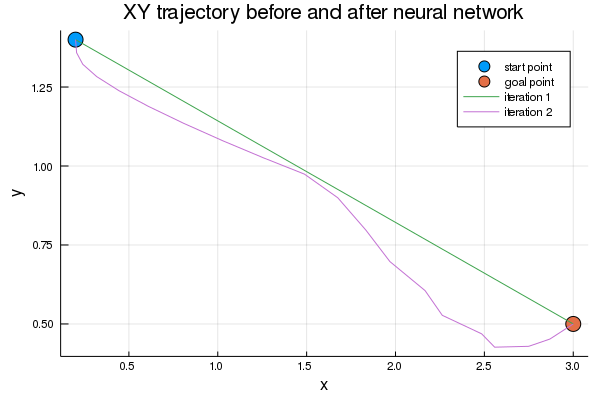

In [176]:
plotXYTrajectories(traj_X_vec)
title!("XY trajectory before and after neural network")

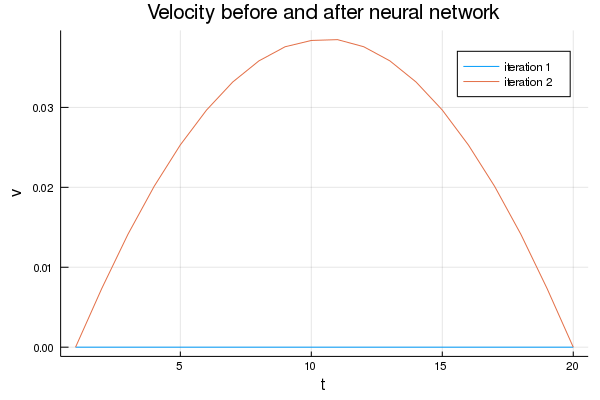

In [177]:
plotVelocities(traj_X_vec)
title!("Velocity before and after neural network")

### Comparison 1: this as a new starting point, compare cost evolution

In [178]:
# Try solving SCP with this new starting point vs with initial straight line

traj_init_NN = Trajectory(output_X, output_Y, 80)
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init_NN, "Ipopt", max_iter=10, print_level=1);
@show TOSgusto.SCPS.J_true
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.iterations
costsWithNNInit = TOSgusto.SCPS.J_true

TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80)
traj_init = init_traj_straightline(TOP)
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=10, print_level=1);
@show TOSgusto.SCPS.J_true
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.iterations
costsWithStraightInit = TOSgusto.SCPS.J_true


(TOSgusto.SCPS).J_true = Any[0.0412636, 0.0572858, 0.0572858, 0.0572858]
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true]
(TOSgusto.SCPS).iterations = 3
(TOSgusto.SCPS).J_true = Any[0.0, 0.0572858, 0.0572858, 0.0572858]
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true]
(TOSgusto.SCPS).iterations = 3


4-element Array{Any,1}:
 0.0                 
 0.05728578731985084 
 0.057285787319852205
 0.0572857873198522  

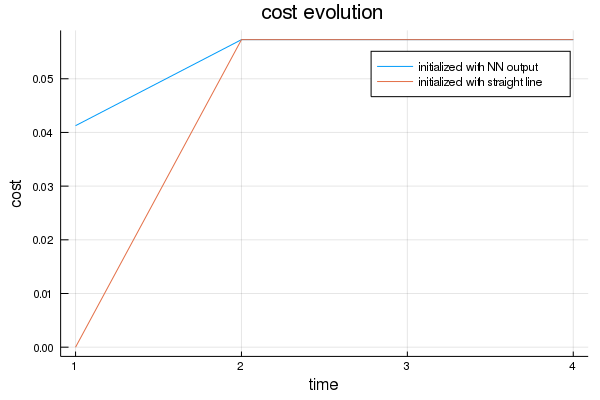

In [179]:
gr(fmt=:png)
plot()
plot!(costsWithNNInit, label = "initialized with NN output")
plot!(costsWithStraightInit, label = "initialized with straight line")
title!("cost evolution")
xlabel!("time")
ylabel!("cost")
plot!()

### Compare the trajectory evolution

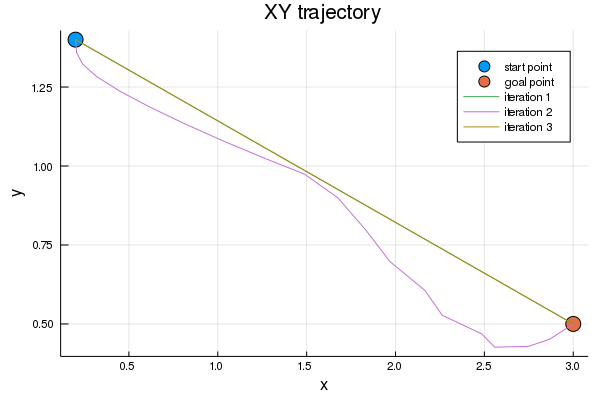

In [181]:
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
plotXYTrajectories(traj_X_vec)


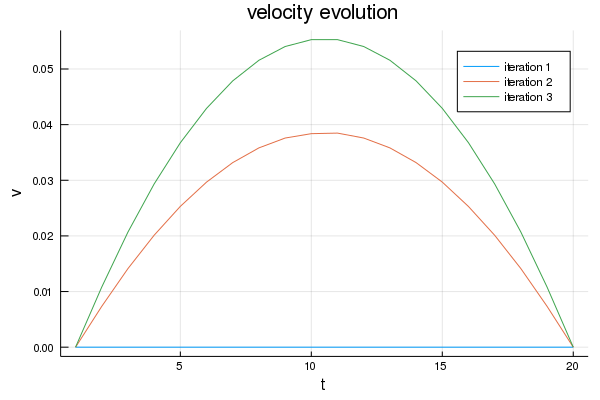

In [182]:
plotVelocities(traj_X_vec)


### Compare time taken

In [298]:
# Try solving SCP with this new starting point vs with initial straight line
setup_time = @elapsed begin
    env = setUpEnvironmentNoObstacle()
    N = 20
    x_goal = [3.; 0.5; 0; 0; 0; 0]
    x_init = [0.2; 1.4; 0; 0; 0; 0] 

    TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
    traj_init = init_traj_straightline(TOP)

    traj_init_X = traj_init.X
    traj_init_U = traj_init.U

    traj_X_vec = [traj_init_X]
    traj_U_vec = [traj_init_U]

    ω0 = 1.0 
    Δ0 = 3.0
    
    load_model_time = @elapsed begin 
        filename = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelParams.h5"
        xMin, yMin, xRange, yRange = getDataParamsFromHDF5(filename)

        NN_input = createNNInput(traj_init_X, traj_init_U, ω0, Δ0, xMin, xRange)

        jsonFileName = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedB.json"
        weightsFileName = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedBWeights.h5"
        NN = Keras.load(jsonFileName, weightsFileName)
    end

end

NN_time = @elapsed begin 
    eval_NN_time = @elapsed NN_output_diff = NN(NN_input)
    output_X, output_U = recoverXUfromNNOutput(NN_output_diff, NN_input, xMin, xRange, yMin, yRange)
end

@show setup_time
@show load_model_time
@show eval_NN_time
@show NN_time

only_gusto_setup_time = @elapsed begin
    TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80)
    traj_init = init_traj_straightline(TOP)
end

first_solve_time = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=1);
second_solve_time = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=1);

println("")
@show only_gusto_setup_time
@show first_solve_time
@show second_solve_time

only_gusto_setup_time = @elapsed begin
    TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80)
    traj_init = init_traj_straightline(TOP)
end

two_solves_time = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=2, print_level=1);
two_more_solves_time = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=2, print_level=1);
next_two_more_solves_time = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=2, print_level=1);
println("")
@show only_gusto_setup_time
@show two_solves_time
@show two_more_solves_time
@show next_two_more_solves_time

NN_time = @elapsed begin 
    NN_output_diff = NN(NN_input)
    output_X, output_U = recoverXUfromNNOutput(NN_output_diff, NN_input, xMin, xRange, yMin, yRange)
end
gusto_solve_time = @elapsed begin
traj_init_NN = Trajectory(output_X, output_Y, 80)
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init_NN, "Ipopt", max_iter=1, print_level=1);
end
println("")
@show NN_time
@show gusto_solve_time

setup_time = 0.311942232
load_model_time = 0.308309251
eval_NN_time = 0.008614934
NN_time = 0.01845355

only_gusto_setup_time = 0.007437149
first_solve_time = 0.164153791
second_solve_time = 0.038025489

only_gusto_setup_time = 0.002228432
two_solves_time = 0.108465299
two_more_solves_time = 0.038044583
next_two_more_solves_time = 0.039479017

NN_time = 0.001826741
gusto_solve_time = 0.09058192


0.09058192

In [322]:
# TODO: compute some error bounds by averaging these

NN_only_setup_times = []
NN_only_eval_NN_times = []
one_gusto_setup_times = [] 
one_gusto_eval_once_times = []
two_gusto_setup_times = []
two_gusto_eval_twice_times = []
NN_then_gusto_eval_NN_times = []
NN_then_gusto_eval_gusto_times = []

for i = 1:20
    setup_time = @elapsed begin
        env = setUpEnvironmentNoObstacle()
        N = 20
        x_goal = [3.; 0.5; 0; 0; 0; 0]
        x_init = [0.2; 1.4; 0; 0; 0; 0] 

        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
        traj_init = init_traj_straightline(TOP)

        traj_init_X = traj_init.X
        traj_init_U = traj_init.U

        traj_X_vec = [traj_init_X]
        traj_U_vec = [traj_init_U]

        ω0 = 1.0 
        Δ0 = 3.0

        filename = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelParams.h5"
        xMin, yMin, xRange, yRange = getDataParamsFromHDF5(filename)

        NN_input = createNNInput(traj_init_X, traj_init_U, ω0, Δ0, xMin, xRange)

        jsonFileName = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedB.json"
        weightsFileName = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedBWeights.h5"
        NN = Keras.load(jsonFileName, weightsFileName)

    end
    push!(NN_only_setup_times, setup_time)
    @show NN_only_setup_times
    
    NN_time = @elapsed begin 
        NN_output_diff = NN(NN_input)
        output_X, output_U = recoverXUfromNNOutput(NN_output_diff, NN_input, xMin, xRange, yMin, yRange)
    end
    push!(NN_only_eval_NN_times, NN_time)

    only_gusto_setup_time = @elapsed begin
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80)
        traj_init = init_traj_straightline(TOP)
    end
    push!(one_gusto_setup_times, only_gusto_setup_time)

    first_solve_time = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=1);
    push!(one_gusto_eval_once_times, first_solve_time)

    only_gusto_setup_time = @elapsed begin
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80)
        traj_init = init_traj_straightline(TOP)
    end
    push!(two_gusto_setup_times, only_gusto_setup_time)

    two_solves_time = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=2, print_level=1);
    push!(two_gusto_eval_twice_times, two_solves_time)

    NN_time = @elapsed begin 
        NN_output_diff = NN(NN_input)
        output_X, output_U = recoverXUfromNNOutput(NN_output_diff, NN_input, xMin, xRange, yMin, yRange)
    end
    push!(NN_then_gusto_eval_NN_times,NN_time)
    
    gusto_solve_time = @elapsed begin
    traj_init_NN = Trajectory(output_X, output_Y, 80)
    TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init_NN, "Ipopt", max_iter=1, print_level=1);
    end
    push!(NN_then_gusto_eval_gusto_times, gusto_solve_time)
end

using StatsBase
NN_only_setup_times = StatsBase.trim(NN_only_setup_times, prop=0.1)
one_gusto_setup_times = StatsBase.trim(one_gusto_setup_times, prop=0.1)
two_gusto_setup_times = StatsBase.trim(two_gusto_setup_times, prop=0.1)
NN_only_eval_NN_times = StatsBase.trim(NN_only_eval_NN_times, prop=0.1)
NN_then_gusto_eval_NN_times = StatsBase.trim(NN_then_gusto_eval_NN_times, prop=0.1)
one_gusto_eval_once_times = StatsBase.trim(one_gusto_eval_once_times, prop=0.1)
two_gusto_eval_twice_times = StatsBase.trim(two_gusto_eval_twice_times, prop=0.1)
NN_then_gusto_eval_gusto_times = StatsBase.trim(NN_then_gusto_eval_gusto_times, prop=0.1)


setup_times = [mean(NN_only_setup_times); mean(one_gusto_setup_times); mean(two_gusto_setup_times); mean(NN_only_setup_times)]
setup_error = [std(NN_only_setup_times); std(one_gusto_setup_times); std(two_gusto_setup_times); std(NN_only_setup_times)]
eval_NN_times = [mean(NN_only_eval_NN_times); 0.0; 0.0; mean(NN_then_gusto_eval_NN_times)]
eval_NN_error = [std(NN_only_eval_NN_times); 0.0; 0.0; std(NN_then_gusto_eval_NN_times)]
eval_gusto_times = [0.0; mean(one_gusto_eval_once_times); mean(two_gusto_eval_twice_times); mean(NN_then_gusto_eval_gusto_times)]
eval_gusto_error = [0.0; std(one_gusto_eval_once_times); std(two_gusto_eval_twice_times); std(NN_then_gusto_eval_gusto_times)]

NN_only_setup_times = Any[0.0248543]
NN_only_setup_times = Any[0.0248543, 0.0315351]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231, 0.0157208]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231, 0.0157208, 0.0306687]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231, 0.0157208, 0.0306687, 0.0305896]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231, 0.0157208, 0.0306687, 0.0305896, 0.0335031]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231, 0.0157208, 0.0306687, 0.0305896, 0.0335031, 2.72027]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231, 0.0157208, 0.0306687, 0.0305896, 0.0335031, 2.72027, 0.0240123]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231, 0.0157208, 0.0306687, 0.0305896, 0.0335031, 2.72027, 0.0240123, 0.0337845]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231, 0.0157208, 0.0306687, 0.0305896, 0.0335031, 2.72027, 0.0240123, 0.0337845, 0.0326069]
NN_on

4-element Array{Float64,1}:
 0.0                 
 0.019073975248688823
 0.013735353874465795
 0.005673447221792007

In [323]:
std(NN_only_setup_times)
@show NN_only_setup_times

NN_only_setup_times = Any[0.0240123, 0.0246486, 0.0248543, 0.0260682, 0.0305896, 0.0306687, 0.0313976, 0.0315351, 0.0326069, 0.0335031, 0.0337845, 0.192342, 0.253111, 0.336044, 0.696563, 0.727325]


16-element Array{Any,1}:
 0.024012341
 0.024648578
 0.024854326
 0.02606824 
 0.030589584
 0.030668743
 0.031397575
 0.031535109
 0.03260686 
 0.033503103
 0.033784534
 0.192341741
 0.2531105  
 0.336044252
 0.696563072
 0.727325395

In [5]:
# @show setup_times
# @show setup_error
# @show eval_NN_times 
# @show eval_NN_error
# @show eval_gusto_times
# @show eval_gusto_error

setup_times = [0.010304352, 0.00417481, 0.00300462, 0.010304352]
# setup_times = [0.158066, 0.00417481, 0.00300462, 0.158066]
setup_error = [0.0236375, 0.00142739, 0.00154445, 0.0236375]
# setup_error = [0.236375, 0.00142739, 0.00154445, 0.236375]
eval_NN_times = [0.0111097, 0.0, 0.0, 0.00181895]
eval_NN_error = [0.00950111, 0.0, 0.0, 0.000465541]
eval_gusto_times = [0.0, 0.0962423, 0.100582, 0.0968139]
eval_gusto_error = [0.0, 0.019074, 0.0137354, 0.00567345]

4-element Array{Float64,1}:
 0.0       
 0.019074  
 0.0137354 
 0.00567345

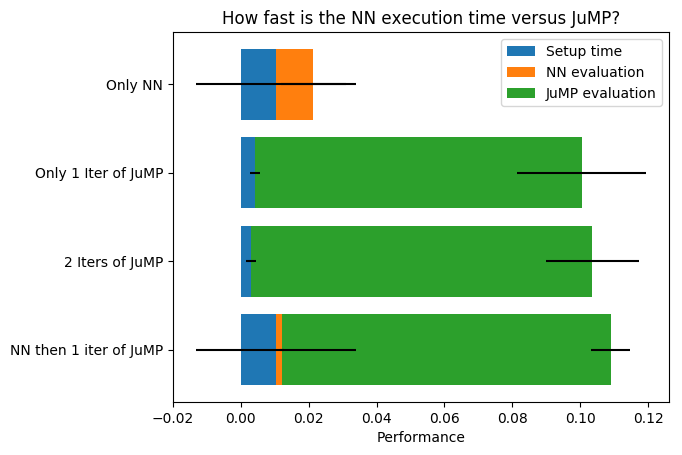

In [6]:
using PyPlot
plt.rcdefaults()
fig, ax = plt.subplots()

cases = ["Only NN", "Only 1 Iter of JuMP", "2 Iters of JuMP", "NN then 1 iter of JuMP"]
y_pos = collect(1:size(cases,1))
# setup_times = [0.010304352; 0.000680142; 0.000816981; 0.010304352]
# eval_NN_times = [0.005939701; 0.0; 0.0; 0.008162978]
# eval_gusto_times = [0.0; 0.078279717; 0.113373914; 0.09058192]

zerror = zeros(size(cases,1))

p1 = plt.barh(y_pos, setup_times, xerr=setup_error, align="center")
p2 = plt.barh(y_pos, eval_NN_times, xerr=eval_NN_error, align="center", left=setup_times)
p3 = plt.barh(y_pos, eval_gusto_times,  xerr=eval_gusto_error, align="center", left=eval_NN_times+setup_times)
ax.set_yticks(y_pos)
ax.set_yticklabels(cases)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Performance")
ax.set_title("How fast is the NN execution time versus JuMP?")
plt.legend(("Setup time","NN evaluation","JuMP evaluation"))
plt.show()

# No obstacle environment

In [8]:
function setUpEnvironmentNoObstacle()
    env = Table(:stanford);
    return env
end

setUpEnvironmentNoObstacle (generic function with 1 method)

# Single obstacle environment

In [9]:
function setUpEnvironmentSingleObstacle(xObs = 1.500, yObs = 1.500, width = 0.27)
    env = Table(:stanford);
    centers = Vector()
    push!(centers, [xObs; yObs; 0.0])

    widths = [width; width; 0.127]
    inflation = 0.05*ones(3)

    for idx in 1:length(centers)
        push!(env.obstacle_set, HyperRectangle(Vec3f0(centers[idx]-0.5*widths-inflation+[0.;0.;0.5*widths[1]]), Vec3f0(widths+2*inflation)))
    end
    return env
end

setUpEnvironmentSingleObstacle (generic function with 4 methods)

# Multiple obstacle environment

In [10]:
function setUpEnvironment()
    env = Table(:stanford);
    centers = Vector()
    push!(centers, [0.460; 0.315; 0.0])
    push!(centers, [0.201; 1.085; 0.0])
    push!(centers, [0.540; 2.020; 0.0])
    push!(centers, [1.374; 0.196; 0.0])
    push!(centers, [1.063; 1.354; 0.0])
    push!(centers, [1.365; 2.322; 0.0])
    push!(centers, [2.221; 0.548; 0.0])
    push!(centers, [2.077; 1.443; 0.0])
    push!(centers, [3.098; 1.186; 0.0])
    push!(centers, [2.837; 2.064; 0.0])
    # push!(centers, [1.500; 1.500; 0.0])

    widths = [0.27; 0.27; 0.127]
    inflation = 0.05*ones(3)

    for idx in 1:length(centers)
        push!(env.obstacle_set, HyperRectangle(Vec3f0(centers[idx]-0.5*widths-inflation+[0.;0.;0.5*widths[1]]), Vec3f0(widths+2*inflation)))
    end
    return env
end

setUpEnvironment (generic function with 1 method)

# Create obstacle grid representation using centers, widths, and inflation
TODO

# Set up problem, initial goal and final goal

In [11]:
function setUpProblem(N, x_init, x_goal;tf_guess = 200.)
    goal_set = GoalSet()
    add_goal!(goal_set, Goal(PointGoal(x_goal), tf_guess, model))
    PD = ProblemDefinition(robot, model, env, x_init, goal_set)
    TOP = TrajectoryOptimizationProblem(PD, N, tf_guess, fixed_final_time=true)
    TOSgusto = TrajectoryOptimizationSolution(TOP)
    return TOP, TOSgusto
end


setUpProblem (generic function with 1 method)

# Create GIF of XY trajectories

In [12]:
function plotGifOfXYTrajectories(X_vec)
    n_iter = size(X_vec,1)
    anim = @animate for i=1:n_iter
        X = X_vec[i]
        plot([X[1,:]],[X[2,:]],
        xlabel = "x",
        ylabel = "y",
        legend = :none)
#         plotSingleXYTrajectory(X_vec[i])
    end
    gif(anim, "/anim_fps15.gif", fps = 15)
    
    
#     @gif for i=1:n_iter
#         plotSingleXYTrajectory(X_vec[i])
#     end every 1
end
plotXYTrajectories(traj_X_vec)


UndefVarError: UndefVarError: plotXYTrajectories not defined

# Plot all trajectory iterations on one plot

In [13]:
function plotXYTrajectories(X_vec)
    n_iter = size(X_vec,1)
    gr(fmt=:png)
    plot()
    for i=1:n_iter
        X = X_vec[i]
        if i==1
            scatter!([X[1,1]],[X[2,1]],label="start point", marker=8)
            scatter!([X[1,end]],[X[2,end]],label="goal point", marker=8)
        end
        
        plot!([X[1,:]],[X[2,:]],
        xlabel = "x",
        ylabel = "y",
        label = "iteration $i",
        title = "XY trajectory")
    end
    plot!()
end


plotXYTrajectories (generic function with 1 method)

# Plot all velocity trajectories on one plot

In [14]:
function plotVelocities(X_vec)
    n_iter = size(X_vec,1)
    gr(fmt=:png)
    plot()
    for i=1:n_iter
        X = X_vec[i]
        N = size(X,2)
        plot!([collect(1:N)],[sqrt.(X[4,:].^2 + X[5,:].^2)],
        xlabel = "t",
        ylabel = "v",
        label = "iteration $i", 
        title = "velocity evolution")
    end
    plot!()
end


plotVelocities (generic function with 1 method)

# Plot single XY trajectory

In [15]:
function plotSingleXYTrajectory(X)
    gr(fmt=:png)
    plot()
    plot!([X[1,:]],[X[2,:]],
        xlabel = "x",
        ylabel = "y",
        legend = :none)
    plot!()
end

plotSingleXYTrajectory (generic function with 1 method)

# Plot velocity along a trajectory

In [16]:
function plotVelocity(X, N)
    gr(fmt=:png)
    plot()
    plot!([collect(1:N)],[sqrt.(X[4,:].^2 + X[5,:].^2)],
        xlabel = "t",
        ylabel = "v",
        legend = :none)
    plot!()
end

plotVelocity (generic function with 1 method)

# Code for animating free-flyer trajectories

In [17]:
function visualizeTraj(env, TOSgusto)
    vis = Visualizer()
    delete!(vis)

    vis[:goal]
    setobject!(vis[:goal][:goal], 
        Object(HyperSphere(Point3(x_goal[1:2]..., robot.r), 0.1),
            MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))

    vis[:table]
    table_dim = env.worldAABBmax-env.worldAABBmin
    setobject!(vis[:table][:table], 
            Object(HyperRectangle(env.worldAABBmin..., table_dim...),
                MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))

    vis[:obstacles]
    for (idx,obs) in enumerate(env.obstacle_set)
        setobject!(vis[:obstacles][Symbol(string("obs",idx))], 
            Object(obs,MeshBasicMaterial(color=RGBA(1.0,0.,0.,0.3))))
    end

    vis[:robot]

    setobject!(vis[:robot][:base],
        Object(Cylinder(Point3f0(0,0,0.),Point3f0(0.,0.,0.5),Float32(robot.r)),MeshBasicMaterial(color=RGBA(0,0.,1.,0.7))))

    up = [0;0;1.]
    q0 = vec2quat(up,x_init[3])
    Qs = Vector{Vector{Float64}}()

    speed_factor = 10

    for k in 1:speed_factor:N
        q = [quat_inv(quat_multiply(mrp2quat([0.; 0.; tan(TOSgusto.SCPS.traj.X[3,k]/4)]), q0)); [TOSgusto.SCPS.traj.X[1:2,k]; robot.r]]
        push!(Qs,q)
    end

    anim = MeshCat.Animation()
    for k in 1:N
        atframe(anim, vis, 5*k) do frame
            settransform!(frame[:robot], Translation(TOSgusto.traj.X[1,k], 
                TOSgusto.traj.X[2,k], TOSgusto.traj.X[3,k]))
        end
    end
    setanimation!(vis, anim)

    # plot_in_cell = true
    plot_in_cell = false
    plot_in_cell ? IJuliaCell(vis) : open(vis)
end

visualizeTraj (generic function with 1 method)

# Get parameters for data like xMin, xRange, etc. from HDF5 file

In [18]:
function getDataParamsFromHDF5(filename)
    f = h5open(filename,"r")
    xMin = read(f["xMin"])
    yMin = read(f["yMin"])
    xRange = read(f["xRange"])
    yRange = read(f["yRange"])
    close(f)
    return xMin, yMin, xRange, yRange 
end


getDataParamsFromHDF5 (generic function with 1 method)

# Create input to neural network from X, U, ω, Δ

In [19]:
function createNNInput(traj_X_vec, traj_U_vec, ω, Δ, xMin, xRange)
    X_row = traj_X_vec[:]'
    U_row = traj_U_vec[:]'
    NN_input = hcat(X_row, U_row, ω, Δ)'
    NN_input = (NN_input-xMin)./xRange
    return NN_input
    
end

createNNInput (generic function with 1 method)

# Recover X,U from neural network output and input

In [20]:
function recoverXUfromNNOutput(NN_output_diff, NN_input, xMin, xRange, yMin, yRange)
    input_true = (NN_input.*xRange)+xMin
    output_diff_true = (NN_output.*yRange)+yMin
    output_true = input_true[1:180] + output_diff_true
    output_X = reshape(output_true[1:120], 6, 20)
    output_U = reshape(output_true[121:180], 3, 20)
    
    return (output_X, output_U)
end

recoverXUfromNNOutput (generic function with 1 method)

# Create Training data from X,U trajectories and trust region values

In [47]:
function createTrainingInputAndOutput(traj_X_vec, traj_U_vec, ω_vec, Δ_vec, dual_vec = nothing)
    X_row = hcat((map(a -> a[:], traj_X_vec))...)'
    U_row = hcat((map(a -> a[:], traj_U_vec))...)'
    if dual_vec != nothing
        dual_row = hcat((map(a -> a[:], dual_vec))...)'
    end
#     @show(size(ω_vec))
#     @show(size(X_row))
    if dual_vec == nothing
        train_input = hcat(X_row, U_row, ω_vec, Δ_vec)[1:end-1,:]
    else
        train_input = hcat(X_row, U_row, ω_vec, Δ_vec, dual_row)[1:end-1,:]
    end

    diff_X = traj_X_vec[2:end]-traj_X_vec[1:end-1]
    diff_U = traj_U_vec[2:end]-traj_U_vec[1:end-1]
    diff_X_row = hcat((map(a -> a[:], diff_X))...)'
    diff_U_row = hcat((map(a -> a[:], diff_U))...)'

    if dual_vec == nothing
        train_output = hcat(diff_X_row, diff_U_row)
    else
        train_output = hcat(diff_X_row, diff_U_row, dual_row[2:end, :])
    end
    
    if size(train_input,1) != size(train_output,1)
        println("ERROR: train input and output have different # of rows")
    end
    if size(train_input,2) - 2 != size(train_output,2)
        println("ERROR: each row of train input should 2 elements more than output")
    end
    
    return train_input, train_output
    
end

createTrainingInputAndOutput (generic function with 2 methods)

# Verify training input and output creation


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

size(traj_X_vec) = (2,)
size(traj_X_vec[1]) = (6, 20)


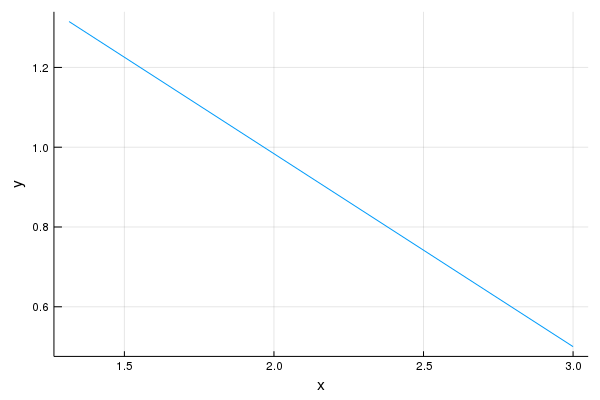

In [30]:
env = setUpEnvironmentSingleObstacle()
xObs = env.obstacle_set[1].origin[1]
yObs = env.obstacle_set[1].origin[2]
N = 20
x_init = [xObs; yObs; 0; 0; 0; 0] # starting inside the obstacle- infeasible
x_goal = [3.; 0.5; 0; 0; 0; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=80);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
@show size(traj_X_vec)
@show size(traj_X_vec[1])
one_X_traj = traj_X_vec[1]
gr(fmt=:png)
plot()
plot!([one_X_traj[1,:]],[one_X_traj[2,:]],
    xlabel = "x",
    ylabel = "y",
    legend = :none)
plot!()


# train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
# @show size(train_input)
# xvals = train_input[1,1:20]
# @show size(xvals)
# yvals = train_input[1,21:40]
# @show size(yvals)
# gr(fmt=:png)
# plot()
# plot!([xvals],[yvals],
#     xlabel = "x",
#     ylabel = "y",
#     legend = :none)
# plot!()

# Recover goal and start points from training data

In [14]:
function recoverProblemConditionsFromTrainInput(train_input) 
    recover_x_init_from_train = train_input[1,1:6]
    @show recover_x_init_from_train
    recover_x_goal_from_train = train_input[1,(6*N-5):(6*N + 1)]
    @show recover_x_goal_from_train
    # NOTE that size(train_input,2)-2 = x_dim * N
end
function recoverProblemConditionsFromTrajVec(traj_X_vec) 
    recover_x_init = traj_X_vec[1][:,1]
    @show recover_x_init
    recover_x_goal = traj_X_vec[1][:,end]
    @show recover_x_goal
    # NOTE that size(traj_X_vec[1]) = (x_dim * N)
end

recoverProblemConditionsFromTrajVec (generic function with 1 method)

# Plot trajectory if starting from within obstacle (infeasible start point)

In [22]:
env = setUpEnvironmentSingleObstacle()
xObs = env.obstacle_set[1].origin[1]
yObs = env.obstacle_set[1].origin[2]
N = 20
x_init = [xObs; yObs; 0; 0; 0; 0] # starting inside the obstacle- infeasible
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=200);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.solver_status
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.converged
iterCount = 1
max_iter = 30
while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.solver_status
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.converged
# Conclusion: if the scp_status never changes to OK, we probably shouldn't store this set of trajectories
# This basically means that GuSTO converged (SCPS.converged) and is "locally solved" (SCPS.solver_status) but never finds an "OK" solution (SCPS.scp_status)

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED]
(TOSgusto.SCPS).accept_solution = Bool[true, true]
(((TOSgusto.SCPS).param).alg).ω_vec = [1.0, 10.0]
(TOSgusto.SCPS).converged = false
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true, true, true]
(((TOSgusto.SCPS).param).alg).ω_vec = [1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
(TOSgusto.SCPS).converged = true


true

# Plot trajectories from GuSTO for no obstacles

## tf = 200 s

In [66]:
env = setUpEnvironmentNoObstacle()
N = 20
x_init = [0.2; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=200);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1
max_iter = 30
while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end

iterCount = 2
iterCount = 3
iterCount = 4


(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK, :OK]


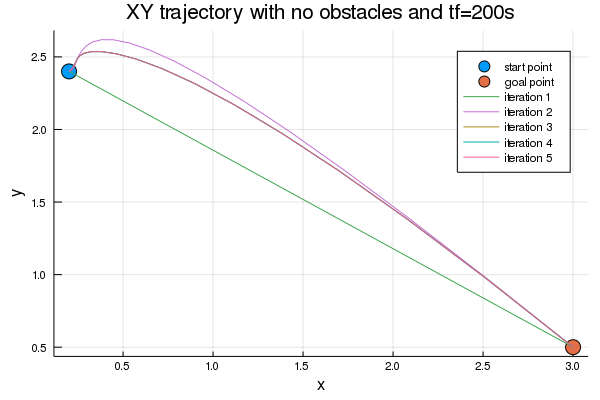

In [67]:
@show TOSgusto.SCPS.scp_status
plotXYTrajectories(traj_X_vec)
title!("XY trajectory with no obstacles and tf=200s")


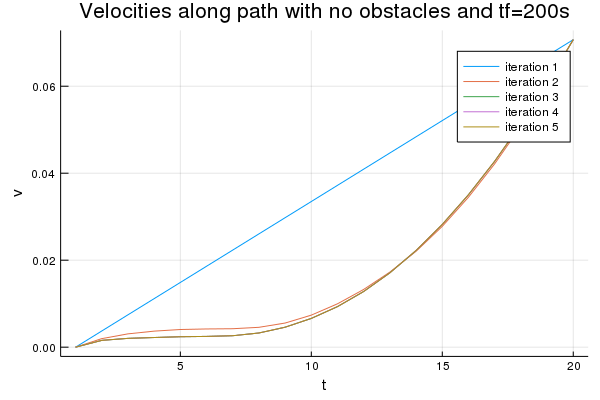

In [17]:
plotVelocities(traj_X_vec)
title!("Velocities along path with no obstacles and tf=200s")

## tf = 50 s

In [39]:
env = setUpEnvironmentNoObstacle()
N = 20
x_init = [2.0; 1.1; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=50);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1
max_iter = 30
while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end

iterCount = 2
iterCount = 3


(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK]


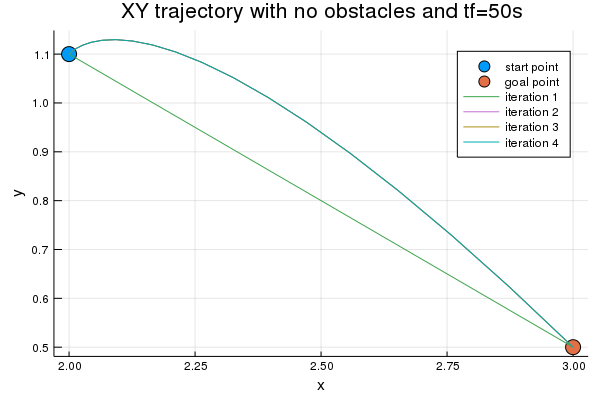

In [40]:
@show TOSgusto.SCPS.scp_status
plotXYTrajectories(traj_X_vec)
title!("XY trajectory with no obstacles and tf=50s")

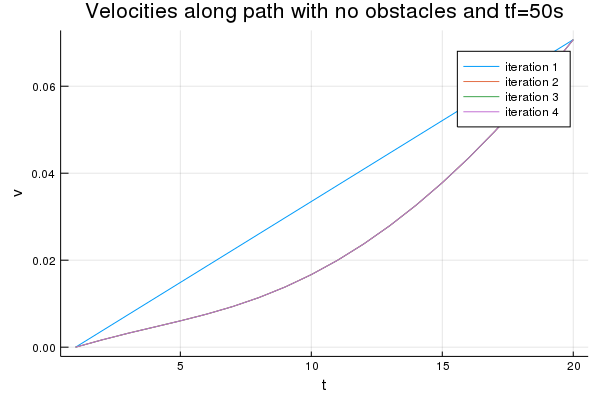

In [41]:
plotVelocities(traj_X_vec)
title!("Velocities along path with no obstacles and tf=50s")

## tf = 400 s

In [23]:
env = setUpEnvironmentNoObstacle()
N = 20
x_init = [0.2; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=400);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1
max_iter = 30
while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end

iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5


(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :ViolatesConstraints, :OK, :OK, :OK]


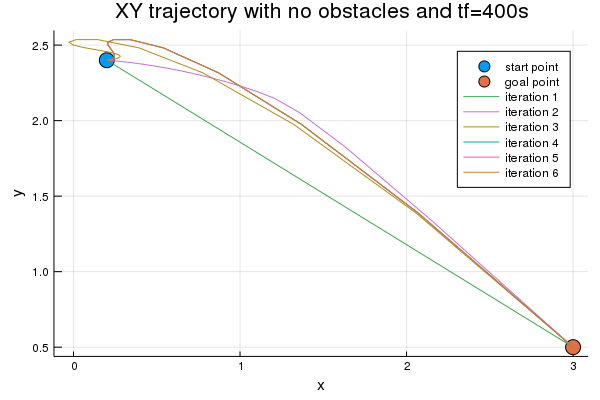

In [24]:
@show TOSgusto.SCPS.scp_status
plotXYTrajectories(traj_X_vec)
title!("XY trajectory with no obstacles and tf=400s")

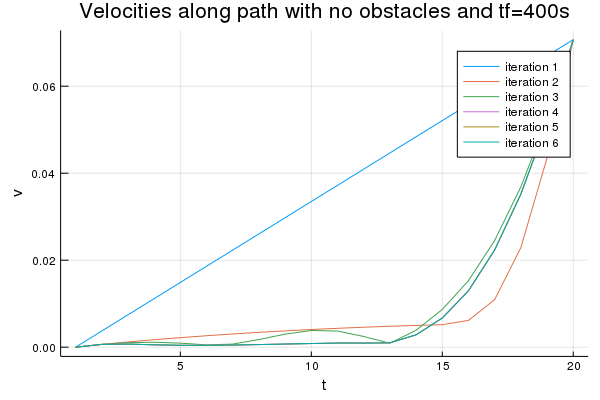

In [25]:
plotVelocities(traj_X_vec)
title!("Velocities along path with no obstacles and tf=400s")

# Plot trajectories from GuSTO for ONE obstacle

## tf = 200s

In [26]:
xObs = 1.500; yObs = 1.500; width = 0.1
env = setUpEnvironmentSingleObstacle(xObs, yObs, width)
N = 20
x_init = [0.2; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=200);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1
max_iter = 30
while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end

iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6


(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :ViolatesConstraints, :OK, :OK, :OK, :OK]


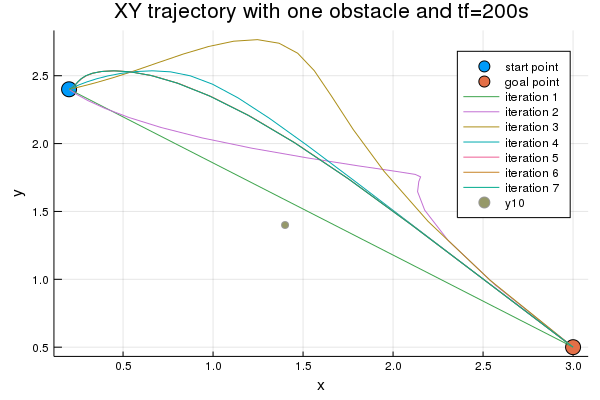

In [27]:
@show TOSgusto.SCPS.scp_status
plotXYTrajectories(traj_X_vec)
title!("XY trajectory with one obstacle and tf=200s")
xObs = env.obstacle_set[1].origin[1]
yObs = env.obstacle_set[1].origin[2]
widthObs = env.obstacle_set[1].widths[1]
scatter!([xObs],[yObs],marker=2*widthObs)


In [28]:
@show env.obstacle_set[1].origin
@show env.obstacle_set[1].widths


(env.obstacle_set[1]).origin = Float32[1.4, 1.4, -0.0635]
(env.obstacle_set[1]).widths = Float32[0.2, 0.2, 0.227]


3-element Vec{3,Float32}:
 0.2  
 0.2  
 0.227

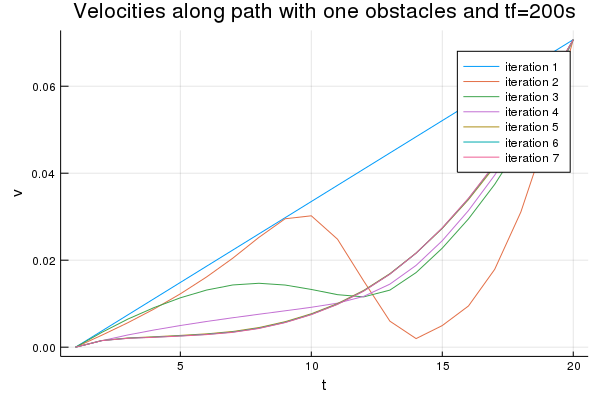

In [29]:
plotVelocities(traj_X_vec)
title!("Velocities along path with one obstacles and tf=200s")

In [30]:
            @show TOSgusto.SCPS.scp_status
            @show TOSgusto.SCPS.solver_status
            @show TOSgusto.SCPS.accept_solution
            @show TOSgusto.SCPS.param.alg.ω_vec

(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :ViolatesConstraints, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true, true, true, true]
(((TOSgusto.SCPS).param).alg).ω_vec = [1.0, 1.0, 10.0, 10.0, 10.0, 10.0, 10.0]


7-element Array{Float64,1}:
  1.0
  1.0
 10.0
 10.0
 10.0
 10.0
 10.0

# Ending with zero velocity or very small velocity results in no change to trajectory

iterCount = 2
iterCount = 3
Saving data solution converged and is OK


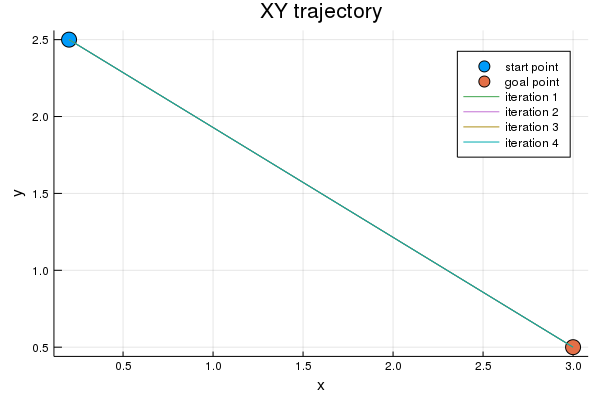

In [34]:
# ZERO VELOCITY
env = setUpEnvironmentNoObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
x_init = [0.2; 2.5; 0; 0; 0; 0] 
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]

# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1

while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
#             @show TOSgusto.SCPS.solver_status[end]
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED 
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end
if TOSgusto.SCPS.scp_status[end] == :OK 
    if TOSgusto.SCPS.converged
        println("Saving data solution converged and is OK")
    else
        println("solution is ok but DID NOT converge")
    end
else
    @show TOSgusto.SCPS.scp_status
    println("solution DID NOT end in OK")
    if TOSgusto.SCPS.converged
        println("solution converged")
    else
        println("solution DID NOT converge")
    end
end
plotXYTrajectories(traj_X_vec)


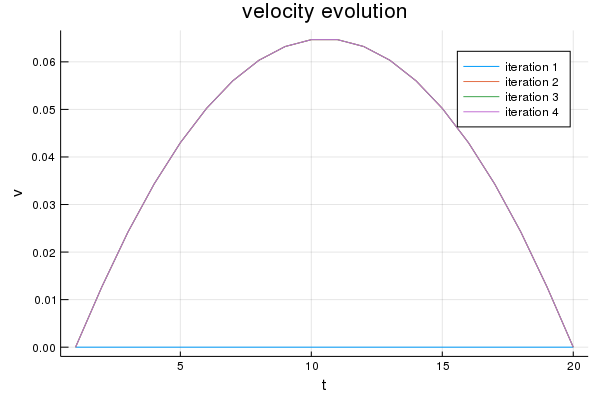

In [35]:
plotVelocities(traj_X_vec)


# Time/benchmark GuSTO

In [14]:
# change default for `seconds` to 1
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 1.0
# change default for `samples` to 10
BenchmarkTools.DEFAULT_PARAMETERS.samples = 3

# Examples of how to time:
# t = @elapsed env = setUpEnvironmentNoObstacle() 

# myenv = @btime setUpEnvironmentNoObstacle()
# @show myenv

# nenv = setUpEnvironmentNoObstacle() 
# tm = @belapsed nenv = setUpEnvironmentNoObstacle() 
# @show tm
# @show nenv

3

In [15]:
# Run everything once just to get things compiled and ready for timing

firstFullTime = @elapsed begin
env = setUpEnvironmentNoObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
num_problems = 10
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 2

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
xVal = xVals[1]
yVal = yVals[1]
x_init = [xVal; yVal; 0; 0; 0; 0] 
firstSetupTime = @elapsed TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
firstSolveTime = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1
firstCreateTrainingTime = @elapsed train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
end

@show firstSetupTime
@show firstSolveTime
@show firstCreateTrainingTime
@show firstFullTime


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

firstSetupTime = 5.002713315
firstSolveTime = 38.92497795
firstCreateTrainingTime = 1.182570358
firstFullTime = 46.972194743


46.972194743

In [21]:
# Time these

setupTimes = []
solveTimes = []
problemTimes = []

env = setUpEnvironmentNoObstacle()

N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
num_problems = 10
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)

max_iter = 2

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        problemTime = @elapsed begin 
        x_init = [xVal; yVal; 0; 0; 0; 0] 
        
        setupTime = @elapsed TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
        push!(setupTimes, setupTime)
            
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        traj_U_vec_first_only = [traj_init.U]
        # Solve one step at a time with IPOPT
        solveTime = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(solveTimes, solveTime)
            
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solveTime = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
            push!(solveTimes, solveTime)
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
#             @show TOSgusto.SCPS.solver_status[end]
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED 
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
#                 @show iterCount
            end
        end
#         if TOSgusto.SCPS.scp_status[end] == :OK 
#             if TOSgusto.SCPS.converged
#                 println("Saving data solution converged and is OK")
#                 train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
#                 train_input_first_only, train_output_first_only = createTrainingInputAndOutput(traj_X_vec_first_only, traj_U_vec_first_only, TOSgusto.SCPS.param.alg.ω_vec[1:2], TOSgusto.SCPS.param.alg.Δ_vec[1:2])
#         #         @show size(train_input)
#         #         @show size(train_output)
#                 train_input_collected = vcat(train_input_collected, train_input)
#                 train_output_collected = vcat(train_output_collected, train_output)
#                 train_input_collected_first_only = vcat(train_input_collected_first_only, train_input_first_only)
#                 train_output_collected_first_only = vcat(train_output_collected_first_only, train_output_first_only)
#             else
#                 println("solution is ok but DID NOT converge")
#             end
#         else
#             @show TOSgusto.SCPS.scp_status
#             println("solution DID NOT end in OK")
#             if TOSgusto.SCPS.converged
#                 println("solution converged")
#             else
#                 println("solution DID NOT converge")
#             end
#         end
        end
        push!(problemTimes, problemTime)
        problemNumber = problemNumber + 1
    end
end

meanSolveTime = mean(solveTimes)
meanProblemTime = mean(problemTimes)
meanNumberOfSolverPerProblem = length(solveTimes)/length(problemTimes)
println("")
println("Mean solve time for solve_SCP!: $meanSolveTime")
println("Mean number of solves per problem: $meanNumberOfSolverPerProblem")
println("Mean problem time: $meanProblemTime")



problemNumber = 1

problemNumber = 2

problemNumber = 3

problemNumber = 4

problemNumber = 5

problemNumber = 6

problemNumber = 7

problemNumber = 8

problemNumber = 9

Mean solve time for solve_SCP!: 0.05211993377777776
Mean number of solves per problem: 3.0
Mean problem time: 0.159812594


# Now train on SINGLE obstacle environments, keep only first 3 iterations, check that final solution in 3 iterations is OK and converges, with Thomas's suggestions

In [17]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironmentSingleObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
num_problems = 1000
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 2

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
#         @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
#             @show TOSgusto.SCPS.solver_status[end]
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED 
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        if TOSgusto.SCPS.scp_status[end] == :OK 
            if TOSgusto.SCPS.converged
                println("Saving data solution converged and is OK")
                train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
        #         @show size(train_input)
        #         @show size(train_output)
                train_input_collected = vcat(train_input_collected, train_input)
                train_output_collected = vcat(train_output_collected, train_output)
            else
                println("solution is ok but DID NOT converge")
            end
        else
            @show TOSgusto.SCPS.scp_status
            println("solution DID NOT end in OK")
            if TOSgusto.SCPS.converged
                println("solution converged")
            else
                println("solution DID NOT converge")
            end
        end

        problemNumber = problemNumber + 1
        @save "SingleObstacleFirst3IterEndsInOKtf80ZeroFinVel.jld2" train_input_collected train_output_collected
    end
end


problemNumber = 1

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 2
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 3
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 4
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 5
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 6
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 7
iterCount = 2
iterCount = 3
Saving data solution converged and is


problemNumber = 69
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 70
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 71
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 72
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 73
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 74
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 75
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 76
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 77
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 78
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 79
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 80
iterCount = 2
iterCount = 


problemNumber = 141
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 142
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 143
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 144
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 145
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 146
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 147
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 148
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 149
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution converged

problemNumber = 150
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstrain


problemNumber = 213
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 214
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 215
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 216
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 217
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution

iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 281
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 282
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 283
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 284
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 285
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 286
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 287
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 288
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 289
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 290
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 291
iterCount = 2
iterCount = 3
solutio


problemNumber = 356
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 357
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 358
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 359
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 360
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 361
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 362
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 363
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 364
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 365
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 366
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesCo


problemNumber = 415
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 416
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 417
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 418
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 419
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 420
iterCount = 2
iterCount = 3
solution is ok but DID NOT con

iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 471
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 472
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 473
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 474
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 475
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :Viol


problemNumber = 524
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 525
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 526
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 527
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 528
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 529
iterCount = 2
iterCount = 3
Saving data solution conv


problemNumber = 575
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 576
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 577
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 578
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 579
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 580
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 581
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 582
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 583
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution converged

problemNumber = 584
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :Vi


problemNumber = 630
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 631
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 632
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 633
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 634
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution


problemNumber = 683
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 684
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 685
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 686
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 687
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 688
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 689
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 690
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 691
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 692
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 693
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNu


problemNumber = 756
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 757
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 758
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 759
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 760
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 761
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 762
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 763
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 764
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 765
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 766
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNu


problemNumber = 829
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 830
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 831
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution converged

problemNumber = 832
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 833
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 834
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT 


problemNumber = 897
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 898
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 899
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 900
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 901
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 902
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 903
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumbe

# Only train on no obstacle environments, keep only first 3 iterations, check that final solution in 3 iterations is OK and converges, with Thomas's suggestions, also store 1st iteration separately


problemNumber = 1
iterCount = 2
iterCount = 3
Saving data solution converged and is OK


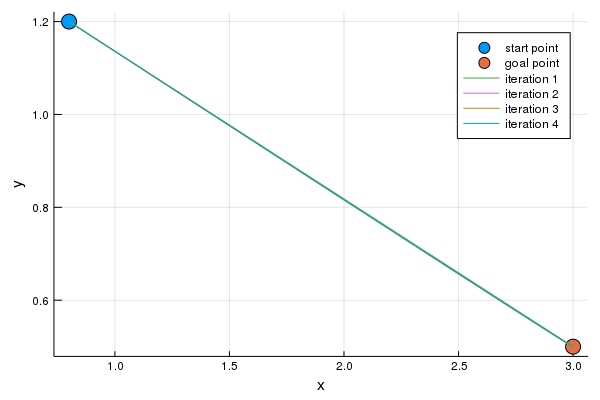

In [28]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironmentNoObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
num_problems = 1000
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 2

train_input_collected_first_only = Array{Float64}(undef,0,182)
train_output_collected_first_only = Array{Float64}(undef,0,180)

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
#         @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        traj_X_vec_first_only = [traj_init.X]
        traj_U_vec_first_only = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        push!(traj_X_vec_first_only, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec_first_only, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
#             @show TOSgusto.SCPS.solver_status[end]
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED 
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        if TOSgusto.SCPS.scp_status[end] == :OK 
            if TOSgusto.SCPS.converged
                println("Saving data solution converged and is OK")
                train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
                train_input_first_only, train_output_first_only = createTrainingInputAndOutput(traj_X_vec_first_only, traj_U_vec_first_only, TOSgusto.SCPS.param.alg.ω_vec[1:2], TOSgusto.SCPS.param.alg.Δ_vec[1:2])
        #         @show size(train_input)
        #         @show size(train_output)
                train_input_collected = vcat(train_input_collected, train_input)
                train_output_collected = vcat(train_output_collected, train_output)
                train_input_collected_first_only = vcat(train_input_collected_first_only, train_input_first_only)
                train_output_collected_first_only = vcat(train_output_collected_first_only, train_output_first_only)
            else
                println("solution is ok but DID NOT converge")
            end
        else
            @show TOSgusto.SCPS.scp_status
            println("solution DID NOT end in OK")
            if TOSgusto.SCPS.converged
                println("solution converged")
            else
                println("solution DID NOT converge")
            end
        end

        problemNumber = problemNumber + 1
        @save "NoObstacleFirst3IterEndsInOKtf80ZeroFinVel.jld2" train_input_collected train_output_collected
        @save "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2" train_input_collected_first_only train_output_collected_first_only
    end
end

# Only train on no obstacle environments and keep only first 2 iterations

In [34]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironmentNoObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
num_problems = 1000
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 2

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
#         @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 50);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        @show size(traj_X_vec)
        @show size(traj_X_vec[1])
        @show size(traj_U_vec[1])
        train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
        @show size(train_input)
        @show size(train_output)
        train_input_collected = vcat(train_input_collected, train_input)
        train_output_collected = vcat(train_output_collected, train_output)
        problemNumber = problemNumber + 1
        @save "NoObstacleFirst3Iter.jld2" train_input_collected train_output_collected
    end
end


problemNumber = 1
iterCount = 2
iterCount = 3
size(traj_X_vec) = (4,)
size(traj_X_vec[1]) = (6, 20)
size(traj_U_vec[1]) = (3, 20)
size(ω_vec) = (4,)
size(X_row) = (4, 120)
size(train_input) = (3, 182)
size(train_output) = (3, 180)

problemNumber = 2
iterCount = 2
iterCount = 3
size(traj_X_vec) = (4,)
size(traj_X_vec[1]) = (6, 20)
size(traj_U_vec[1]) = (3, 20)
size(ω_vec) = (4,)
size(X_row) = (4, 120)
size(train_input) = (3, 182)
size(train_output) = (3, 180)

problemNumber = 3
iterCount = 2
iterCount = 3
size(traj_X_vec) = (4,)
size(traj_X_vec[1]) = (6, 20)
size(traj_U_vec[1]) = (3, 20)
size(ω_vec) = (4,)
size(X_row) = (4, 120)
size(train_input) = (3, 182)
size(train_output) = (3, 180)

problemNumber = 4
iterCount = 2
iterCount = 3
size(traj_X_vec) = (4,)
size(traj_X_vec[1]) = (6, 20)
size(traj_U_vec[1]) = (3, 20)
size(ω_vec) = (4,)
size(X_row) = (4, 120)
size(train_input) = (3, 182)
size(train_output) = (3, 180)

problemNumber = 5
iterCount = 2
iterCount = 3
size(traj_X_vec) = (4,)
s

InterruptException: InterruptException:

# Only train on single obstacle environments and keep only first 4 iterations

In [ ]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironmentSingleObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
num_problems = 1000
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 4

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
#         @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 50);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
#         @show size(train_input)
#         @show size(train_output)
        train_input_collected = vcat(train_input_collected, train_input)
        train_output_collected = vcat(train_output_collected, train_output)
        problemNumber = problemNumber + 1
        @save "SingleObstacleFirst5Iter.jld2" train_input_collected train_output_collected
    end
end


problemNumber = 1

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

iterCount = 2
iterCount = 3

problemNumber = 2
iterCount = 2
iterCount = 3

problemNumber = 3
iterCount = 2
iterCount = 3

problemNumber = 4
iterCount = 2
iterCount = 3

problemNumber = 5
iterCount = 2
iterCount = 3

problemNumber = 6
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 7
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 8
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 9
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 10
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 11
iterCount = 2
iterCount = 3
iterCount = 4

problemN

iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 117
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 118
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 119
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 120
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 121
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 122
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 123
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 124
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 125
iterCount = 2
iterCount = 3

problemNumber = 126
iterCount = 2
iterCount = 3

problemNumber = 127
iterCount = 2
iterCount = 3

problemNumber = 128
iterCount = 2
iterCount = 3

problemNumber = 129
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 130
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 131

iterCount = 4
iterCount = 5

problemNumber = 234
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 235
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 236
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 237
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 238
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 239
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 240
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 241
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 242
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 243
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 244
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 245
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 246
iterCount = 2
iterCount = 3
iterCount = 4

iterCount = 4

problemNumber = 349
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 350
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 351
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 352
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 353
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 354
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 355
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 356
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 357
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 358
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 359
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 360
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 361
iterCount = 2
iterCount = 3
iterCount = 4

iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 462
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 463
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 464
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 465
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 466
iterCount = 2
iterCount = 3

problemNumber = 467
iterCount = 2
iterCount = 3

problemNumber = 468
iterCount = 2
iterCount = 3

problemNumber = 469
iterCount = 2
iterCount = 3

problemNumber = 470
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 471
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 472
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 473
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 474
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 475
iterCount = 2
iterCount = 3
iterCount = 4
iterCo

iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 578
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 579
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 580
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 581
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 582
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 583
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 584
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 585
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 586
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 587
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 588
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 589
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 590
iterCount = 2
iterCount = 3

problemNumber = 591
iterCount = 2
iterCount = 3

problemNumber = 592

iterCount = 3
iterCount = 4

problemNumber = 708
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 709
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 710
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 711
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 712
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 713
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 714
iterCount = 2
iterCount = 3

problemNumber = 715
iterCount = 2
iterCount = 3

problemNumber = 716
iterCount = 2
iterCount = 3

problemNumber = 717
iterCount = 2
iterCount = 3

problemNumber = 718
iterCount = 2
iterCount = 3

problemNumber = 719
iterCount = 2
iterCount = 3

problemNumber = 720
iterCount = 2
iterCount = 3

problemNumber = 721
iterCount = 2
iterCount = 3

problemNumber = 722
iterCount = 2
iterCount = 3

problemNumber = 723
iterCount = 2
iterCount = 3

problemNumber = 724


problemNumber = 859
iterCount = 2
iterCount = 3

problemNumber = 860
iterCount = 2
iterCount = 3

problemNumber = 861
iterCount = 2
iterCount = 3

problemNumber = 862
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 863
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 864
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 865
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 866
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 867
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 868
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 869
iterCount = 2
iterCount = 3

problemNumber = 870
iterCount = 2
iterCount = 3

problemNumber = 871
iterCount = 2
iterCount = 3

problemNumber = 872
iterCount = 2
iterCount = 3

problemNumber = 873
iterCount = 2
iterCount = 3

problemNumber = 874
iterCount = 2
iterCount = 3

problemNumber = 875
iterCount = 2
iterCount = 3

problemNumber = 876
iterCo

# Code for second batch of training data

In [ ]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironment()
N = 20
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
num_problems = 1000
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 30

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
#         @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
#         @show size(train_input)
#         @show size(train_output)
        train_input_collected = vcat(train_input_collected, train_input)
        train_output_collected = vcat(train_output_collected, train_output)
        problemNumber = problemNumber + 1
        @save "secondBatch.jld2" train_input_collected train_output_collected
    end
end

# @save "firstBatch.jld2" train_input_collected train_output_collected


# Code for first batch of training data

In [ ]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironment()
N = 20
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
num_problems = 100
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 30

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
        @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
            @show TOSgusto.SCPS.scp_status
            @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
        @show size(train_input)
        @show size(train_output)
        train_input_collected = vcat(train_input_collected, train_input)
        train_output_collected = vcat(train_output_collected, train_output)
        problemNumber = problemNumber + 1
        @save "firstBatch.jld2" train_input_collected train_output_collected
    end
end

# @save "firstBatch.jld2" train_input_collected train_output_collected


In [ ]:
# Violates constraints start point
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
# Solve full solution with IPOPT
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=100, print_level=0);


In [ ]:
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec

In [ ]:
# Violates constraints start point
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);

traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1

while !TOSgusto.SCPS.converged && iterCount <=50
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    push!(traj_X_vec, TOSgusto.SCPS.traj.X)
    push!(traj_U_vec, TOSgusto.SCPS.traj.U)
    iterCount = iterCount + 1
    @show iterCount 
#     @show TOSgusto.SCPS.param.alg.ω_vec
#     @show TOSgusto.SCPS.param.alg.Δ_vec
end
println("Finished!")
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show size(traj_X_vec)



In [ ]:
train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
@show size(train_input)
@show size(train_output)


In [ ]:
traj_X_vec_3d=cat(traj_X_vec...,dims=3)
@show size(traj_X_vec_3d)

using JLD2, FileIO
hello = "world"
foo = :bar
@save "example.jld2" hello foo

In [ ]:
# OK start point
env = setUpEnvironment()
N = 20
x_init = [0.2; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
# Solve full solution with IPOPT
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=100, print_level=0);


In [ ]:
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec

In [ ]:
plotVelocity(TOSgusto.SCPS.traj.X, N)
plotXYTrajectory(TOSgusto.SCPS.traj.X)

In [ ]:
visualizeTraj(env, TOSgusto)

In [ ]:
# Solve full solution with Gurobi
env = setUpEnvironment()
N = 20
x_init = [0.4; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", max_iter=100, OutputFlag=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.accept_solution
# visualizeTraj(env, TOSgusto)

In [ ]:
# Create loop to run SCP one iteration at a time and store off TOSgusto.SCPS.traj as well as parameters
first_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=1, print_level=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.traj.U
@show TOSgusto.SCPS.traj.Tf
@show TOSgusto.SCPS.traj.dt
@show TOSgusto.SCPS.iterations


# @show TOSgusto.SCPS.converged
# @show TOSgusto.SCPS.dual


In [ ]:
second_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.traj.U
@show TOSgusto.SCPS.traj.Tf
@show TOSgusto.SCPS.traj.dt
@show TOSgusto.SCPS.iterations


In [ ]:
for i in 1:20
    next_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    @show TOSgusto.SCPS.scp_status
    @show TOSgusto.SCPS.param.alg.ω_vec
    @show TOSgusto.SCPS.param.alg.Δ_vec
    @show TOSgusto.SCPS.traj.X
    @show TOSgusto.SCPS.traj.U
    @show TOSgusto.SCPS.traj.Tf
    @show TOSgusto.SCPS.traj.dt
    @show TOSgusto.SCPS.iterations
end

In [ ]:
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=100, print_level=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.traj.U
@show TOSgusto.SCPS.traj.Tf
@show TOSgusto.SCPS.traj.dt
@show TOSgusto.SCPS.iterations

In [ ]:
include("../ok.jl")

In [ ]:
# @show TOSgusto.SCPS.param.alg.ω_vec
function ok()
    print("thiss2")
end
ok()

In [ ]:
SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
@show TOSgusto.SCPS.dual
@show TOSgusto.SCPS.traj
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec

In [ ]:
using Profile
using ProfileView 
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
Profile.clear()
@profile solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", OutputFlag=0)
ProfileView.view()

In [ ]:
using Profile
using ProfileView 
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
Profile.clear()
@profile solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", print_level=0)
ProfileView.view()

In [ ]:
SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", OutputFlag=0);
# SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", print_level=0);


In [ ]:
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.total_time
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.solver_status
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.convergence_measure
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.J_true
@show TOSgusto.SCPS.dual
;

In [ ]:
@show TOSgusto.SCPS.traj


In [ ]:
typeof(TOSgusto.SCPS.traj)


In [ ]:
# Old version of code
# # Violates constraints start point
# env = setUpEnvironment()
# N = 20
# x_init = [0.6; 2.4; 0; 0; 0; 0]
# x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
# TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
# if isdefined(TOSgusto, :SCPS)
#     println("Before first, TOSgusto.SCPS defined")
# else
#     println("Before first, TOSgusto.SCPS NOT defined")
# end
# # Solve one step at a time with IPOPT
# solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=1, print_level=0);
# # @show typeof(TOSgusto.SCPS.SCPP.param.alg)
# iterCount = 1
# if isdefined(TOSgusto.SCPS.param, :alg)
#     println("After first, TOSgusto.SCPS.param.alg defined")
# else
#     println("After first, TOSgusto.SCPS.param.alg NOT defined")
# end
# while !TOSgusto.SCPS.converged && iterCount <=15
#     solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#     iterCount = iterCount + 1
#     @show iterCount 
#     @show TOSgusto.SCPS.param.alg.ω_vec
#     @show TOSgusto.SCPS.param.alg.Δ_vec
# end
# println("Finished!")
# @show TOSgusto.SCPS.scp_status
# @show TOSgusto.SCPS.iterations
# @show TOSgusto.SCPS.converged
# @show TOSgusto.SCPS.param.alg.ω_vec
# @show TOSgusto.SCPS.param.alg.Δ_vec